In [1]:
%matplotlib notebook
import numpy as np
import os,sys
from scipy import misc
from matplotlib import pyplot as plt
import pickle as pk
from PIL import Image
from astropy.io import fits
from scipy import ndimage
from skimage import exposure

nsimilar = 50
scale=200.0

def plot_trc_box(ax, trc_in, clr, dd):
    ax.plot([trc_coords[trc_in, 1], trc_coords[trc_in, 1],
                                                            trc_coords[trc_in, 1]+xs,
                                                            trc_coords[trc_in, 1]+xs,trc_coords[trc_in, 1]],
             [trc_coords[trc_in, 0], trc_coords[trc_in, 0]+xs, trc_coords[trc_in, 0]+xs,
             trc_coords[trc_in, 0],trc_coords[trc_in, 0]], color=clr, alpha=np.clip(1.0/dd, 0.2, 1))


def dist2D(a):
    N = a.shape[0]
    A = np.matlib.repmat(a[:,0], N,1)
    B = np.matlib.repmat(a[:,0][np.newaxis,:].T, 1,N)

    C = np.matlib.repmat(a[:,1], N,1)
    D = np.matlib.repmat(a[:,1][np.newaxis,:].T, 1,N)

    return np.sqrt((A-B)**2 + (C-D)**2)

In [2]:
# Load the TIFF file
im = Image.open('/home/ec2-user/data_carina/carina.tiff')
imarr = np.asarray(im)

# Create trc_coords
xs = 224
nx =np.int(imarr.shape[0]/xs)-1
ny =np.int(imarr.shape[1]/xs)-1
stride = 4
trc_coords = np.zeros([nx*ny*stride*stride, 2])
images = np.zeros([xs, xs, 3, nx*ny*stride*stride], dtype=np.int8)
for i in np.arange(nx*stride):
    for j in np.arange(ny*stride):
        trc_coords[int(j+i*ny*stride), 0] = int(i*xs/stride)
        trc_coords[int(j+i*ny*stride), 1] = int(j*xs/stride)

# Load the
images = np.load('/home/ec2-user/data_carina/carina_224.npy', mmap_mode='r')

# Load the coordinates.
tsne = np.load('/home/ec2-user/data_carina/carina_tsne_coords.npy', mmap_mode='r')

# Create mapping
dist_tsne_grid = dist2D(tsne)
dist_real_grid = dist2D(trc_coords)
diag = np.zeros([tsne.shape[0], tsne.shape[0]])
diag = 1-np.diag(np.ones((tsne.shape[0],)))

wh = np.asarray(np.where(np.ravel((dist_tsne_grid < 1) & (dist_real_grid > 1024) & (diag == 1.0))))

(3528, 2548, 3)


In [32]:
axarr = [None, None]

def show_base_carina():
    axarr[0].cla()
    axarr[0].imshow(np.asarray(im), origin='upper')
    axarr[0].axis('off')
    axarr[0].set_title('Carina Image')

def show_base_tSNE():
    axarr[1].cla()
    axarr[1].scatter(tsne[:,0], tsne[:, 1])
    axarr[1].set_xlim((-100,100))
    axarr[1].set_ylim((-100,100))
    axarr[1].set_title('tSNE Reduced')
    
def init_plot():
    plt.figure(1, figsize=(10, 6))
    axarr[0] = plt.subplot(1,2,1)
    axarr[1] = plt.subplot(1,2,2)
    
    show_base_carina()    
    show_base_tSNE()
    plt.gcf().text(0.02, 0.02, 'Space Telescope Science Institute -- Craig Jones, Josh Peek, Jonathan Hargis')

    #return axarr

def show_point(x,y, evaxis):    

    # Display the base Carina image (no boxes on it)
    show_base_carina()
    
    # Display the base tSNE scatter plot
    show_base_tSNE()

    if evaxis == axarr[0]:
        #Center of the box is at the middle of the 224x224 box
        x, y = int(x), int(y)
        x = x - 112
        y = y - 112
        trc_in = np.argmin((trc_coords[:,0]-x)**2+(trc_coords[:,1]-y)**2)
    else:
        trc_in = np.argmin((tsne[:,0]-y)**2+(tsne[:,1]-x)**2)
        
    dists = np.ravel(dist_tsne_grid[trc_in, :])
    closest = (np.argsort(dists))[0:nsimilar]

    # Plot on carina image
    for i in closest:
        plot_trc_box(axarr[0], i, 'yellow', dists[i])
    plot_trc_box(axarr[0], trc_in, 'red', 0.0001)

    # Plot on tSNE scatter plot
    for i in closest:
        axarr[1].scatter(tsne[i,0], tsne[i, 1], facecolors=None, edgecolor='yellow', alpha=np.clip(2.0/dists[i], 0.2, 1))
    axarr[1].scatter(tsne[trc_in,0], tsne[trc_in, 1], facecolors='red', edgecolor='red')
    axarr[1].set_aspect(1.3)
    

<IPython.core.display.Javascript object>


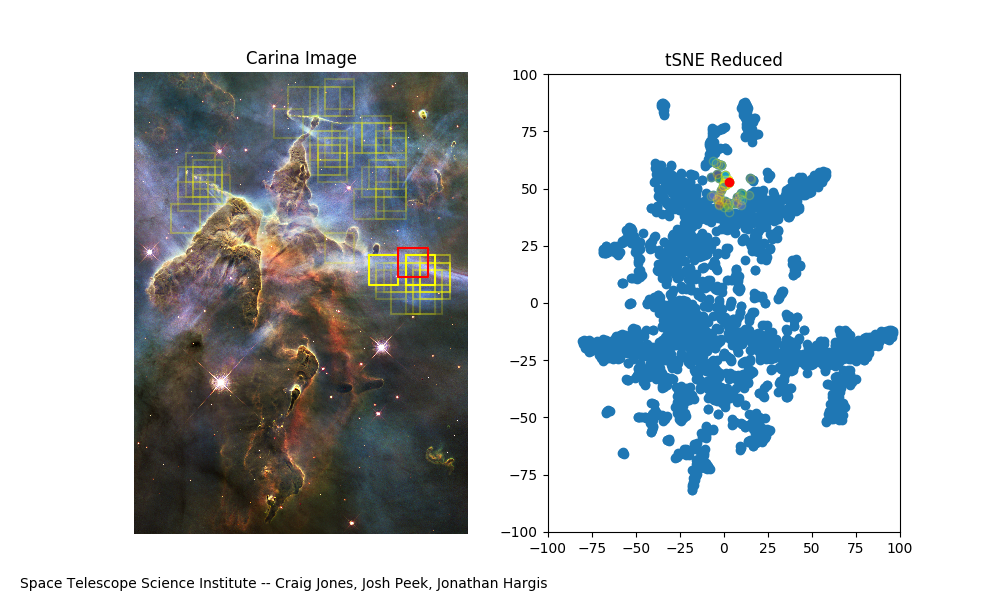

In [33]:
def onclick(event):
    show_point(event.ydata, event.xdata, event.inaxes)

init_plot()
cid = plt.figure(1).canvas.mpl_connect('button_press_event', onclick)
